NYU Center for Data Science

DS-GA 1003 Machine Learning

HW7 - Computation Graphs, Back-propagation, and Neural Networks

Stephen Spivack (ss7726@nyu.edu)

In [1]:
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import nodes
import graph
import plot_utils
import pdb
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs

### 1) Introduction

There is no doubt that neural networks are a very important class of machine learning models. Given the sheer number of people who are achieving impressive results with neural networks, one might think that it’s relatively easy to get them working. This is a partly an illusion. One reason so many people have success is that, thanks to GitHub, they can copy the exact settings that others have used to achieve success. In fact, in most cases they can start with “pre-trained” models that already work for a similar problem, and “fine-tune” them for their own purposes. It’s far easier to tweak and improve a working system than to get one working from scratch. If you create a new model, you’re kind of on your own to figure out how to get it working: there’s not much theory to guide you and the rules of thumb do not always work. Understanding even the most basic questions, such as the preferred variant of SGD to use for optimization, is still a very active area of research. 

One thing is clear, however: If you do need to start from scratch, or debug a neural network model that doesn’t seem to be learning, it can be immensely helpful to understand the low-level details of how your neural network works – specifically, back-propagation. With this assignment, you’ll have the opportunity to linger on these low-level implementation details. Every major neural network type (RNNs, CNNs, Resnets, etc.) can be implemented using the basic framework we’ll develop in this assignment.

To help things along, Philipp Meerkamp, Pierre Garapon, and David Rosenberg have designed a minimalist framework for computation graphs and put together some support code. The intent is for you to read, or at least skim, every line of code provided, so that you’ll know you understand all the crucial components and could, in theory, create your own from scratch. In fact, creating your own computation graph framework from scratch is highly encouraged – you’ll learn a lot.

### 2) Computation Graph Framework

To get started, please read the tutorial on the computation graph framework we’ll be working with. (Note that it renders better if you view it locally.) The use of computation graphs is not specific to machine learning or neural networks. Computation graphs are just a way to represent a function that facilitates efficient computation of the function’s values and its gradients with respect to inputs. The tutorial takes this perspective, and there is very little in it about machine learning, per se.

To see how the framework can be used for machine learning tasks, we’ve provided a full implementation of linear regression. You should start by working your way through the `__init__` of the `LinearRegression` class in `linear_regression.py`. From there, you’ll want to review the node class definitions in `nodes.py`, and finally the class `ComputationGraphFunction` in `graph.py`. `ComputationGraphFunction` is where we repackage a raw computation graph into something that’s more friendly to work with for machine learning. The rest of `linear_regression.py` is fairly routine, but it illustrates how to interact with the `ComputationGraphFunction`.

As we’ve noted earlier in the course, getting gradient calculations correct can be difficult. To help things along, we’ve provided two functions that can be used to test the backward method of a node and the overall gradient calculation of a `ComputationGraphFunction`. The functions are in `test_utils.py`, and it’s recommended that you review the tests provided for the linear regression implementation in `linear regression.t.py`. (You can run these tests from the command line with python3 `linear_regression.t.py`.) The functions actually doing the testing, test node backward and test `ComputationGraphFunction`, may seem a bit intricate, but they’re implementing the exact same gradient checker logic we saw in the second homework assignment.

Once you’ve understood how linear regression works in our framework, you’re ready to start implementing your own algorithms. To help you get started, please make sure you are able to execute the following commands:
 - cd/path/to/hw7
 - python3 linear regression.py
 - python3 linear regression.t.py

### 3) Ridge Regression

When moving to a new system, it’s always good to start with something familiar. But that’s not the only reason we’re doing ridge regression in this homework. In ridge regression the parameter vector is “shared”, in the sense that it’s used twice in the objective function. In the computation graph, this can be seen in the fact that the node for the parameter vector has two outgoing edges. This sharing is common in many popular neural networks (RNNs and CNNs), where it is often referred to as parameter tying.

`ridge_regression.py` provides a skeleton code and `ridge_regression.t.py` is a test code, which you should eventually be able to pass.

1) Complete the class `L2NormPenaltyNode` in `nodes.py`. If your code is correct, you should be able to pass `test_L2NormPenaltyNode` in `ridge_regression.t.py`. Please attach a screenshot that shows the test results for this question.

In [2]:
class L2NormPenaltyNode(object):
    """ Node computing l2_reg * ||w||^2 for scalars l2_reg and vector w"""
    def __init__(self, l2_reg, w, node_name):
        """ 
        Parameters:
        l2_reg: a numpy scalar array (e.g. np.array(.01)) (not a node)
        w: a node for which w.out is a numpy vector
        node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.l2_reg = np.array(l2_reg)
        self.w = w

    def forward(self):
        self.out = self.l2_reg * np.dot(self.w.out, self.w.out)
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        self.w.d_out += 2*self.l2_reg*self.d_out*self.w.out
        return self.d_out

    def get_predecessors(self):
        return self.w

2) Complete the class `SumNode` in `nodes.py`. If your code is correct, you should be able to pass test `SumNode` in `ridge_regression.t.py`. Please attach a screenshot that shows the test results for this question.

In [3]:
class SumNode(object):
    """ Node computing a + b, for numpy arrays a and b"""
    def __init__(self, a, b, node_name):
        """ 
        Parameters:
        a: node for which a.out is a numpy array
        b: node for which b.out is a numpy array of the same shape as a
        node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.b = b
        self.a = a

    def forward(self):
        self.out = self.a.out + self.b.out
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        self.a.d_out += self.d_out
        self.b.d_out += self.d_out
        return self.d_out

    def get_predecessors(self):
        return self.a, self.b

3) Implement ridge regression with $w$ regularized and $b$ unregularized. Do this by completing the `__init__` method in `ridge_regression.py`, using the classes created above. When complete, you should be able to pass the tests in `ridge_regression.t.py`. Report the average square error on the training set for the parameter settings given in the `main()` function.

In [4]:
class RidgeRegression(BaseEstimator, RegressorMixin):
    """ Ridge regression with computation graph """
    def __init__(self, l2_reg=1, step_size=.005,  max_num_epochs = 5000):
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size

        # Build computation graph
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response
        self.w = nodes.ValueNode(node_name="w") # to hold the parameter vector
        self.b = nodes.ValueNode(node_name="b") # to hold the bias parameter (scalar)

        # Build computation graph
        self.l2_reg = [l2_reg]
        self.inputs = [self.x]
        self.outcomes = [self.y]
        self.parameters = [self.w, self.b]
        
        self.prediction = nodes.VectorScalarAffineNode(x=self.x, w=self.w, b=self.b, node_name="prediction")
        self.loss = nodes.SquaredL2DistanceNode(a=self.prediction, b=self.y, node_name="square loss")
        self.penalty = nodes.L2NormPenaltyNode(l2_reg=self.l2_reg, w=self.w, node_name="l2 penalty")
        self.objective = nodes.SumNode(a=self.loss, b=self.penalty, node_name="penalized square loss")
        
        self.graph = graph.ComputationGraphFunction(self.inputs, self.outcomes, self.parameters, 
                                                    self.prediction, self.objective)

        
    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)

        init_parameter_values = {"w": np.zeros(num_ftrs), "b": np.array(0.0)}
        self.graph.set_parameters(init_parameter_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                #print(obj)
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                self.graph.increment_parameters(steps)

            if epoch % 50 == 0:
                train_loss = sum((y - self.predict(X,y)) **2)/num_instances
                print("Epoch ",epoch,": Ave objective=",epoch_obj_tot/num_instances," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction(input_values={"x":X[j]})

        return preds

In [5]:
def main():
    data_fname = "data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = setup_problem.load_problem(data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    X = featurize(x)

    l2reg = 1
    estimator = RidgeRegression(l2_reg=l2reg, step_size=0.00005, max_num_epochs=2000)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })


    l2reg = 0
    estimator = RidgeRegression(l2_reg=l2reg, step_size=0.0005, max_num_epochs=500)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", 
                     "coefs": coefs_true, "preds": target_fn(x)})

    plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

Epoch  0 : Ave objective= [1.62373167]  Ave training loss:  0.8219384059292827
Epoch  50 : Ave objective= [0.32767635]  Ave training loss:  0.24165706231898207
Epoch  100 : Ave objective= [0.31588735]  Ave training loss:  0.21171391682692733
Epoch  150 : Ave objective= [0.31450184]  Ave training loss:  0.20352262568181054
Epoch  200 : Ave objective= [0.31313379]  Ave training loss:  0.20042808359365882
Epoch  250 : Ave objective= [0.3124578]  Ave training loss:  0.19907150636038817
Epoch  300 : Ave objective= [0.31182157]  Ave training loss:  0.1986141899377338
Epoch  350 : Ave objective= [0.31170646]  Ave training loss:  0.19802823788751994
Epoch  400 : Ave objective= [0.31139657]  Ave training loss:  0.1983130147683462
Epoch  450 : Ave objective= [0.30911393]  Ave training loss:  0.1988048353655947
Epoch  500 : Ave objective= [0.31052365]  Ave training loss:  0.1977896661490063
Epoch  550 : Ave objective= [0.3087419]  Ave training loss:  0.19885285716877615
Epoch  600 : Ave objective

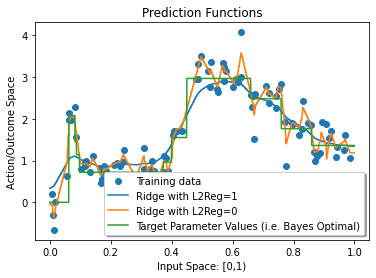

In [6]:
main()

### 4) Multilayer Perceptron

Let’s now turn to a multilayer perceptron (MLP) with a single hidden layer and a square loss.

The crucial new piece here is the nonlinear hidden layer, which is what makes the multilayer perceptron a significantly larger hypothesis space than linear prediction functions.

#### 4.1) The standard non-linear layer

The multilayer perceptron consists of a sequence of “layers” implementing the following non-linear function

$h(x) = \sigma (Wx + b)$,

where $x \in \mathbb{R}^d, W \in \mathbb{R}^{m \times d}$ and $b \in \mathbb{R}^m$ and where $m$ is often referred to as the number of hidden units or hidden nodes. $\sigma$ is some non-linear function, typically tanh or ReLU, applied element-wise to the argument of $\sigma$. Referring to the computation graph illustration above, we will implement this nonlinear layer with two nodes, one implementing the affine transform $L = W_1x + b_1$, and the other implementing the nonlinear function $h = tanh(L)$. In this problem, we’ll work out how to implement the backward method for each of these nodes.

#### The Affine Transformation

In a general neural network, there may be quite a lot of computation between any given affine transformation $Wx + b$ and the final objective function value $J$. We will capture all of that in a function $f : \mathbb{R}^m \rightarrow \mathbb{R}$, for which $J = f(Wx + b)$. Our goal is to find the partial derivative of $J$ with respect to each element of $W$, namely $\partial J / \partial W_{i,j}$, as well as the partials $\partial J / \partial b_{i}$, for each element of $b$. For convenience, let $y = Wx+b$, so we can write $J = f(y)$. Suppose we have already computed the partial derivatives of $J$ with respect to the entries of $y = (y_1, ..., y_m)^T$, namely $\frac{\partial J}{\partial y_i}$ for $i = 1, ..., m$. Then by the chain rule, we have

$$\frac{\partial J}{\partial W_{i,j}} = \sum_{r=1}^m \frac{\partial J}{\partial y_r} \frac{\partial y_r}{\partial W_{i,j}}$$.

4) Show that $\frac{\partial J}{\partial W_{i,j}} = \frac{\partial J}{\partial y_i} x_j$, where $x = (x_1, ..., x_d)^T$.

$\frac{\partial J}{\partial W_{i,j}} = \sum_{r=1}^m \frac{\partial J}{\partial y_r} \frac{\partial y_r}{\partial W_{i,j}} = \frac{\partial J}{\partial y_i} \frac{\partial y_i}{\partial W_{i,j}} = \frac{\partial J}{\partial y_i} x_j$

5) Now let's vectorize this. Let's write $\frac{\partial J}{\partial y} \in \mathbb{R}^{m \times 1}$ for the column vector whose $i$th entry is $\frac{\partial J}{\partial y_i}$. Let's also define the matrix $\frac{\partial J}{\partial W} \in \mathbb{R}^{m \times d}$, whose $ij$th entry is $\frac{\partial J}{\partial W_{i,j}}$. Generally speaking, we'll always take $\frac{\partial J}{\partial A}$ to be an array of the same size as $A$. Give a vectorized expression for $\frac{\partial J}{\partial W}$ in terms of the column vectors $\frac{\partial J}{\partial y}$ and $x$.

From the previous question we have $\frac{\partial J}{\partial W_{i,j}} = \frac{\partial J}{\partial y_i} x_j$.

This gives us $\frac{\partial J}{\partial W} = \frac{\partial J}{\partial y} x^\top$.

6) In the usual way, define $\frac{\partial J}{\partial x} \in \mathbb{R}^d$, whose $i$th entry is $\frac{\partial J}{\partial x_i}$. Show that $\frac{\partial J}{\partial x} = W^T (\frac{\partial J}{\partial y})$.

First we use the chain rule to compute

$\frac{\partial J}{\partial x_i} = \sum_{j=1}^m \frac{\partial J}{\partial y_j} \frac{\partial y_j}{\partial x_i} = \sum_{j=1}^m \frac{\partial J}{\partial y_j} W_{j,i}$.

From here we have that

$\frac{\partial J}{\partial x} = \frac{\partial J}{\partial f(x)} \frac{\partial f(x)}{\partial x} = W^T (\frac{\partial J}{\partial y})$.

7) Show that $\frac{\partial J}{\partial b} = \frac{\partial J}{\partial y}$, where $\frac{\partial J}{\partial b}$ is defined in the usual way.

$\frac{\partial J}{\partial b} = \frac{\partial J}{\partial y} \frac{\partial y}{\partial b} = \frac{\partial J}{\partial y}$.

#### Element-wise Transformers

Our nonlinear activation function nodes take an array (e.g. a vector, matrix, higher-order tensor, etc), and apply the same nonlinear transformation $\sigma : \mathbb{R} → \mathbb{R}$ to every element of the array. Let’s abuse notation a bit, as is usually done in this context, and write $\sigma(A)$ for the array that results from applying $\sigma(·)$ to each element of $A$. If $\sigma$ is differentiable at $x \in \mathbb{R}$, then we’ll write $\sigma′(x)$ for the derivative of $\sigma$ at $x$, with $\sigma′(A)$ defined analogously to $\sigma(A)$.

Suppose the objective function value $J$ is written as $J = f(\sigma(A))$, for some function $f : S \rightarrow \mathbb{R}$, where $S$ is an array of the same dimensions as $\sigma(A)$ and $A$. As before, we want to find the array $\frac{\partial J}{\partial A}$ for any $A$. Suppose for some $A$ we have already computed the array $\frac{\partial J}{\partial S} = \frac{\partial f(S)}{\partial S}$ for we’re dealing with arrays of arbitrary shapes, it can be tricky to write down the chain rule. Appropriately, we’ll use a tricky convention: We’ll assume all entries of an array $A$ are indexed by a single variable. So, for example, to sum over all entries of an array $A$, we’ll just write $\Sigma_i A_i$.

8) Show that $\frac{\partial J}{\partial A} = \frac{\partial J}{\partial S} \otimes \sigma′(A)$, where we’re using $\otimes$ to represent the Hadamard product. If $A$ and $B$ are arrays of the same shape, then their Hadamard product $A \otimes B$ is an array with the same shape as $A$ and $B$, and for which $(A \otimes B) = A_i B_i$. That is, it’s just the array formed by multiplying corresponding elements of $A$ and $B$. Conveniently, in numpy if $A$ and $B$ are arrays of the same shape, then $A*B$ is their Hadamard product.

$\frac{\partial J}{\partial A} = \frac{\partial J}{\partial S} \frac{\partial S}{\partial A} = \frac{\partial J}{\partial S} \otimes \sigma'(A)$.

#### 4.2) MLP Implementation

9) Complete the class `AffineNode` in `nodes.py`. Be sure to propagate the gradient with respect to $x$ as well, since when we stack these layers, $x$ will itself be the output of another node that depends on our optimization parameters. If your code is correct, you should be able to pass test `AffineNode` in `mlp_regression.t.py`. Please attach a screenshot that shows the test results for this question.

In [7]:
class AffineNode(object):
    """Node implementing affine transformation (W,x,b)-->Wx+b, where W is a matrix,
    and x and b are vectors
        Parameters:
        W: node for which W.out is a numpy array of shape (m,d)
        x: node for which x.out is a numpy array of shape (d)
        b: node for which b.out is a numpy array of shape (m) (i.e. vector of length m)
    """
    def __init__(self, W, x, b, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.W = W
        self.x = x
        self.b = b

    def forward(self):
        self.out = np.dot(self.W.out, self.x.out) + self.b.out
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        self.W.d_out += np.outer(self.d_out, self.x.out)
        self.x.d_out += np.dot(self.W.out.T, self.d_out)
        self.b.d_out += self.d_out
        return self.d_out

    def get_predecessors(self):
        return self.W, self.x, self.b

10) Complete the class `TanhNode` in `nodes.py`. As you’ll recall, $\frac{d}{dx} tanh(x) = 1 - tanh^2 x$. Note that in the forward pass, we’ll already have computed $tanh$ of the input and stored it in `self.out`. So make sure to use `self.out` and not recalculate it in the backward pass. If your code is correct, you should be able to pass test `TanhNode` in `mlp_regression.t.py`. Please attach a screenshot that shows the test results for this question.

In [8]:
class TanhNode(object):
    """Node tanh(a), where tanh is applied elementwise to the array a
        Parameters:
        a: node for which a.out is a numpy array
    """
    def __init__(self, a, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.a = a

    def forward(self):
        self.out = np.tanh(self.a.out)
        self.d_out = np.zeros(self.out.shape)
        return self.out      

    def backward(self):
        self.a.d_out += self.d_out*(1 - self.out**2)
        return self.d_out
    
    def get_predecessors(self):
        return [self.a]

11) Implement an MLP by completing the skeleton code in `mlp_regression.py` and making use of the nodes above. Your code should pass the tests provided in `mlp_regression.t.py`. Note that to break the symmetry of the problem, we initialize our weights to small random values, rather than all zeros, as we often do for convex optimization problems. Run the MLP for the two settings given in the `main()` function and report the average training error. Note that with an MLP, we can take the original scalar as input, in the hopes that it will learn nonlinear features on its own, using the hidden layers. In practice, it is quite challenging to get such a neural network to fit as well as one where we provide features.

In [9]:
class MLPRegression(BaseEstimator, RegressorMixin):
    """ MLP regression with computation graph """
    def __init__(self, num_hidden_units=10, step_size=.005, init_param_scale=0.01, max_num_epochs=5000):
        self.num_hidden_units = num_hidden_units
        self.init_param_scale = init_param_scale
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size

        # Build computation graph
        self.x = nodes.ValueNode(node_name="x")
        self.y = nodes.ValueNode(node_name="y")
        self.W1 = nodes.ValueNode(node_name="W1") 
        self.w2 = nodes.ValueNode(node_name="w2")  
        self.b1 = nodes.ValueNode(node_name="b1") 
        self.b2 = nodes.ValueNode(node_name="b2") 
        
        self.affine = nodes.AffineNode(W=self.W1, x=self.x, b=self.b1, node_name="affine")
        self.tanh = nodes.TanhNode(a=self.affine, node_name="tanh")
        self.prediction = nodes.VectorScalarAffineNode(x=self.tanh, w=self.w2, b=self.b2, node_name="prediction")
        self.objective = nodes.SquaredL2DistanceNode(a=self.prediction, b=self.y, node_name="square loss")
        self.inputs = [self.x]
        self.outcomes = [self.y]
        self.parameters = [self.W1, self.b1, self.w2, self.b2]
        self.graph = graph.ComputationGraphFunction(self.inputs, self.outcomes, self.parameters, 
                                                    self.prediction, self.objective)

    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)
        s = self.init_param_scale
        init_values = {"W1": s * np.random.standard_normal((self.num_hidden_units, num_ftrs)),
                       "b1": s * np.random.standard_normal((self.num_hidden_units)),
                       "w2": s * np.random.standard_normal((self.num_hidden_units)),
                       "b2": s * np.array(np.random.randn()) }

        self.graph.set_parameters(init_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                #print(obj)
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                self.graph.increment_parameters(steps)
                #pdb.set_trace()

            if epoch % 50 == 0:
                train_loss = sum((y - self.predict(X,y)) **2)/num_instances
                print("Epoch ",epoch,": Ave objective=",epoch_obj_tot/num_instances," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction(input_values={"x":X[j]})

        return preds

def main():
    data_fname = "data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = setup_problem.load_problem(data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", "coefs": coefs_true, "preds": target_fn(x)})

    estimator = MLPRegression(num_hidden_units=10, step_size=0.001, init_param_scale=.0005,  max_num_epochs=5000)
    x_train_as_column_vector = x_train.reshape(x_train.shape[0],1) # fit expects a 2-dim array
    x_as_column_vector = x.reshape(x.shape[0],1) # fit expects a 2-dim array
    estimator.fit(x_train_as_column_vector, y_train)
    name = "MLP regression - no features"
    pred_fns.append({"name":name, "preds": estimator.predict(x_as_column_vector) })
    #plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    if (1==1):
        X = featurize(x)
        estimator = MLPRegression(num_hidden_units=10, step_size=0.0005, init_param_scale=.01,  max_num_epochs=500)
        estimator.fit(X_train, y_train)
        name = "MLP regression - with features"
        pred_fns.append({"name":name, "preds": estimator.predict(X) })
        plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

Epoch  0 : Ave objective= 3.134582925990716  Ave training loss:  2.717585236966511
Epoch  50 : Ave objective= 0.9453605494045125  Ave training loss:  0.9434921263545675
Epoch  100 : Ave objective= 0.9448740150819788  Ave training loss:  0.9430065961768267
Epoch  150 : Ave objective= 0.94008773628877  Ave training loss:  0.9380470818250314
Epoch  200 : Ave objective= 0.9025784981825281  Ave training loss:  0.899510091380863
Epoch  250 : Ave objective= 0.8074981046869825  Ave training loss:  0.80330633601
Epoch  300 : Ave objective= 0.7728631475418568  Ave training loss:  0.7693251919329656
Epoch  350 : Ave objective= 0.7692029339804145  Ave training loss:  0.7654447968712411
Epoch  400 : Ave objective= 0.7655525519994242  Ave training loss:  0.7623438807843362
Epoch  450 : Ave objective= 0.7627240790296226  Ave training loss:  0.758566098530834
Epoch  500 : Ave objective= 0.7577684408088399  Ave training loss:  0.7539672450679734
Epoch  550 : Ave objective= 0.7526991614221018  Ave train

Epoch  4700 : Ave objective= 0.24890171272612488  Ave training loss:  0.2447079272235213
Epoch  4750 : Ave objective= 0.24898600212166616  Ave training loss:  0.2436376631763025
Epoch  4800 : Ave objective= 0.24602271719408253  Ave training loss:  0.2449421688184652
Epoch  4850 : Ave objective= 0.24711681647367026  Ave training loss:  0.2421428665953104
Epoch  4900 : Ave objective= 0.2461762714373549  Ave training loss:  0.2427901371875478
Epoch  4950 : Ave objective= 0.24645720166869595  Ave training loss:  0.24106191273058364
Epoch  0 : Ave objective= 3.1634727061766763  Ave training loss:  2.533014608688897
Epoch  50 : Ave objective= 0.1474567650810708  Ave training loss:  0.14485969661263887
Epoch  100 : Ave objective= 0.11783763869107597  Ave training loss:  0.10884198228382588
Epoch  150 : Ave objective= 0.09966679546125246  Ave training loss:  0.09267148076759632
Epoch  200 : Ave objective= 0.08510066822385294  Ave training loss:  0.08701125746119995
Epoch  250 : Ave objective= 

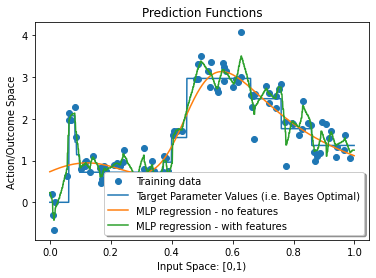

In [10]:
main()

#### 4.3) Multiclass classification with an MLP

We consider a generic classification problem with $K$ classes over inputs $x$ of dimension $d$. Using a MLP we will compute a K-dimensional vector $z$ representing scores,

$z = W_2 tanh(W_1x + b_1) + b_2$,

with $W_1 \in \mathbb{R}^{m \times d}, b_1 \in \mathbb{R}^m, W_2 \in \mathbb{R}^{K \times m}$ and $b_1 \in \mathbb{R}^K$. Our model assumes that $x$ belongs to class $k$ with probability 

$$ \frac{e^{z_k}}{\sum_{k=1}^K e^{z_k}}$$,

which corresponds to applying a Softmax to the scores. Given this probabilistic model we can
train the model by minimizing the negative log-likelihood.

12) Implement a Softmax node. We provided skeleton code for class `SoftmaxNode` in `nodes.py`. If your code is correct, you should be able to pass test `SoftmaxNode` in `multiclass.t.py`. Please attach a screenshot that shows the test results for this question.

In [11]:
class SoftmaxNode(object):
    """ Softmax node
    Parameters:
    z: node for which z.out is a numpy array
    """
    def __init__(self, z, node_name):
        self.z = z
        self.node_name = node_name
    
    def forward(self):
        exp_array = np.exp(self.z.out)
        self.out = exp_array / sum(exp_array)
        self.d_out = np.zeros( ( self.out.shape[0]) )
        return self.out
    
    def backward(self):
        out_vector = self.out.reshape((-1,1))
        dz = np.diagflat(self.out) - np.dot(out_vector, out_vector.T)
        d_z_prime = self.d_out @ dz.T
        self.z.d_out += d_z_prime
        return self.d_out

    def get_predecessors(self):
        return [self.z]

13) Implement a negative log-likelihood loss node for multiclass classification. We provided skeleton code for class `NLLNode` in `nodes.py`. The test code for this question is combined with the test code for the next question.

In [12]:
class NLLNode(object):
    """ 
    Node computing NLL loss between 2 arrays.
    Parameters:
    y_hat: a node that contains all predictions
    y_true: a node that contains all labels
    """
    def __init__(self, y_hat, y_true, node_name):
        self.y_hat = y_hat
        self.y_true = y_true
        self.node_name = node_name
    
    def forward(self):
        self.out = -np.sum(np.log(self.y_hat.out) * self.y_true.out)
        self.d_out = np.zeros((self.out.shape))
        return self.out

    def backward(self):
        d_y_hat = -self.y_true.out / self.y_hat.out
        self.y_hat.d_out += d_y_hat
        return self.d_out

    def get_predecessors(self):
        return [self.y_hat, self.y_true]

14) Implement a MLP for multiclass classification by completing the skeleton code in `multiclass.py`. Your code should pass the tests in test multiclass provided in `multiclass.t.py`. Please attach a screenshot that shows the test results for this question.

In [13]:
def calculate_nll(y_preds, y):
    """
    Function that calculate the average NLL loss
    :param y_preds: N * C probability array
    :param y: N int array
    :return:
    """
    return np.mean(-np.log(y_preds)[np.arange(len(y)),y])


class MulticlassClassifier(BaseEstimator, RegressorMixin):
    """ Multiclass prediction """
    def __init__(self, num_hidden_units=10, step_size=.005, init_param_scale=0.01, max_num_epochs = 1000,num_class=3):
        self.num_hidden_units = num_hidden_units
        self.init_param_scale = init_param_scale
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size
        self.num_class = num_class

        # Build computation graph
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response
        self.W1 = nodes.ValueNode(node_name="W1") 
        self.b1 = nodes.ValueNode(node_name="b1") 
        self.W2 = nodes.ValueNode(node_name="W2")
        self.b2 = nodes.ValueNode(node_name="b2") 

        self.affine = nodes.AffineNode(W=self.W1, x=self.x, b=self.b1, node_name="affine")
        self.tanh = nodes.TanhNode(a=self.affine, node_name="tanh")
        self.z = nodes.AffineNode(W=self.W2, x=self.tanh, b=self.b2, node_name="z")
        self.prediction = nodes.SoftmaxNode(z=self.z, node_name="softmax")
        self.objective = nodes.NLLNode(y_hat=self.prediction, y_true=self.y, node_name="objective")

        self.inputs = [self.x]
        self.outcomes = [self.y]
        self.parameters = [self.W1, self.b1, self.W2, self.b2]

        self.graph = graph.ComputationGraphFunction(self.inputs, self.outcomes, self.parameters,
                                                    self.prediction, self.objective)

    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)
        s = self.init_param_scale
        init_values = {"W1": s * np.random.standard_normal((self.num_hidden_units, num_ftrs)),
                       "b1": s * np.random.standard_normal((self.num_hidden_units)),
                       "W2": np.random.standard_normal((self.num_class, self.num_hidden_units)),
                       "b2": np.array(np.random.randn(self.num_class)) }
        self.graph.set_parameters(init_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                #print(obj)
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                self.graph.increment_parameters(steps)
                #pdb.set_trace()

            if epoch % 50 == 0:
                train_loss = calculate_nll(self.predict(X,y), y)
                print("Epoch ",epoch," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = []
        for j in range(num_instances):
            preds.append(self.graph.get_prediction(input_values={"x":X[j]}).reshape(1,-1))

        return np.concatenate(preds, axis=0)



def main():
    # load the data from HW5
    np.random.seed(2)
    X, y = make_blobs(n_samples=500, cluster_std=.25, centers=np.array([(-3, 1), (0, 2), (3, 1)]))
    training_X = X[:300]
    training_y = y[:300]
    test_X = X[300:]
    test_y = y[300:]

    # train the model
    estimator = MulticlassClassifier()
    estimator.fit(training_X, training_y)

    # report test accuracy
    test_acc = np.sum(np.argmax(estimator.predict(test_X), axis=1)==test_y)/len(test_y)
    print("Test set accuracy = {:.3f}".format(test_acc))
    

In [14]:
main()

Epoch  0  Ave training loss:  1.2804811701572762
Epoch  50  Ave training loss:  1.0997568044242503
Epoch  100  Ave training loss:  1.0996151323138286
Epoch  150  Ave training loss:  1.0996051349956877
Epoch  200  Ave training loss:  1.099606801297931
Epoch  250  Ave training loss:  1.0995959107479139
Epoch  300  Ave training loss:  1.0995781074890405
Epoch  350  Ave training loss:  1.0996008692290764
Epoch  400  Ave training loss:  1.099569408694711
Epoch  450  Ave training loss:  1.0995853395444528
Epoch  500  Ave training loss:  1.099545724618268
Epoch  550  Ave training loss:  1.0995291657390731
Epoch  600  Ave training loss:  1.0995310905592404
Epoch  650  Ave training loss:  1.0995336049792093
Epoch  700  Ave training loss:  1.0995304373971244
Epoch  750  Ave training loss:  1.0995109832078152
Epoch  800  Ave training loss:  1.099503561975737
Epoch  850  Ave training loss:  1.0994956604985167
Epoch  900  Ave training loss:  1.0994992869881182
Epoch  950  Ave training loss:  1.0995